<a href="https://colab.research.google.com/github/sierrareschke/brain_mri_cnn/blob/main/brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


#Dataset import (Set as required, now it is set to current directory)
data_dir = "/content/drive/MyDrive/MRI_dataset" # only finds 4 images if use MRI_dataset folder
train_dir = pathlib.Path(data_dir + "/Training")
val_dir = pathlib.Path(data_dir + "/Testing")
data_dir = pathlib.Path(data_dir)

#Data count
image_count = len(list(data_dir.glob('**/*.jpg')))
print("Image count: ")
print(image_count)

#Batch definition

batch_size = 32
img_height = 180
img_width = 180

#Split data for training and validation

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  #validation_split=0.2,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Class definition
class_names = train_ds.class_names
print(class_names)

#Tune for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Rescale
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
num_classes = 4

Image count: 
3264
Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
# Basic ResNet Building Block


def resnet_layer(inputs,
                num_filters=16,
                kernel_size=3,
                strides=1,
                activation='relu',
                batch_normalization=True, conv_first = True):
    conv=Conv2D(num_filters,
                kernel_size=kernel_size,
                strides=strides,
                padding='same',
                kernel_initializer='he_normal',
                kernel_regularizer=l2(1e-4))

    x=inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
             x = Activation(activation)(x)
        x = conv(x)
    return x


# ResNet V2 architecture
def resnet_v2(input_shape, depth, num_classes=10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n + 2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 model (Functional)          (None, 10)                910442    
                                                                 
Total params: 910,442
Trainable params: 905,226
Non-trainable params: 5,216
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 model (Functional)          (None, 10)                910442    
                                                                 
Total params: 910,442


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


90/90 [==============================] - 987s 2s/step - loss: 1.5612 - accuracy: 0.6199 - val_loss: 23.1056 - val_accuracy: 0.2690 - lr: 0.0010
Learning rate:  0.001
Epoch 2/80
90/90 [==============================] - 47s 521ms/step - loss: 1.2693 - accuracy: 0.7275 - val_loss: 9.2998 - val_accuracy: 0.3883 - lr: 0.0010
Learning rate:  0.001
Epoch 3/80
90/90 [==============================] - 46s 511ms/step - loss: 1.1775 - accuracy: 0.7463 - val_loss: 5.9580 - val_accuracy: 0.4086 - lr: 0.0010
Learning rate:  0.001
Epoch 4/80
90/90 [==============================] - 46s 515ms/step - loss: 1.0769 - accuracy: 0.7969 - val_loss: 3.6376 - val_accuracy: 0.4061 - lr: 0.0010
Learning rate:  0.001
Epoch 5/80
90/90 [==============================] - 46s 513ms/step - loss: 1.0269 - accuracy: 0.7976 - val_loss: 8.1032 - val_accuracy: 0.2766 - lr: 0.0010
Learning rate:  0.001
Epoch 6/80
90/90 [==============================] - 46s 514ms/step - loss: 0.9873 - accuracy: 0.8000 - val_loss: 8.1594 - 

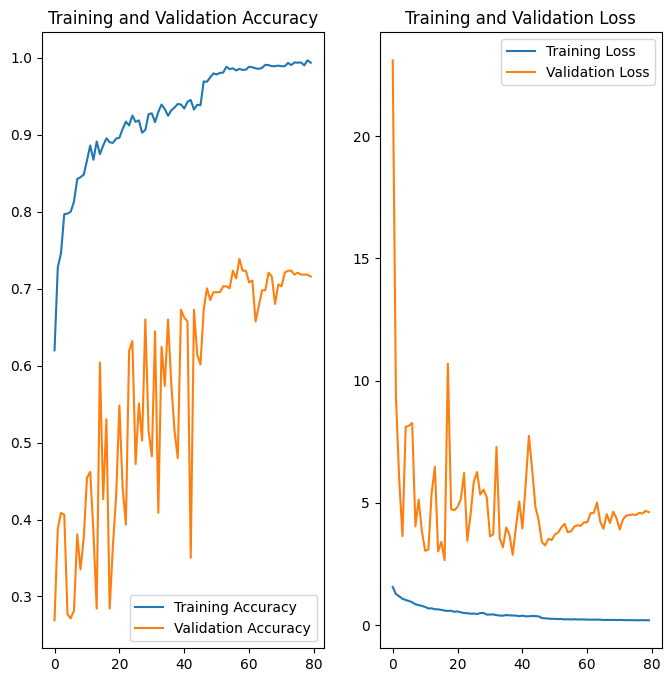

In [ ]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
n = 3
depth = n * 9 + 2
input_shape=(img_height, img_width, 3)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  resnet_v2(input_shape = input_shape, depth = depth)
])
# model = resnet_v2(input_shape = input_shape, depth = depth)

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 70:
      lr = 1e-5
    elif epoch > 45:
        lr = 1e-4
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
                               cooldown = 0,
                               patience = 5,
                               min_lr = 0.5e-6)
callbacks = [lr_reducer, lr_scheduler]

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
# model.compile(loss ='categorical_crossentropy',
#               optimizer = Adam(learning_rate = lr_schedule(0)),
#               metrics =['accuracy'])
model.summary()
with tf.device('/device:GPU:0'):
  epochs = 80
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = callbacks
  )

#New results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
